In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_path = '../data/immunomodulation/log_normalized/regression/'

In [3]:
# Unimol Embeddings
train_X = np.load(data_path + 'train/unimol_embeddings.npy')
validation_X = np.load(data_path + 'validation/unimol_embeddings.npy')
test_X = np.load(data_path + 'test/unimol_embeddings.npy')

In [4]:
train_Y = pd.read_csv(data_path + 'train/y.csv')
validation_Y = pd.read_csv(data_path + 'validation/y.csv')
test_Y = pd.read_csv(data_path + 'test/y.csv')

train_STD = pd.read_csv(data_path + 'train/std.csv')
validation_STD = pd.read_csv(data_path + 'validation/std.csv')
test_STD = pd.read_csv(data_path + 'test/std.csv')

properties = train_Y.columns

In [5]:
# Convert data to Tensors
train_X = torch.tensor(train_X, dtype=torch.float32).detach().to(device)
validation_X = torch.tensor(validation_X, dtype=torch.float32).detach().to(device)
test_X = torch.tensor(test_X, dtype=torch.float32).detach().to(device)

train_Y = torch.tensor(train_Y.to_numpy(), dtype=torch.float32).detach().to(device)
validation_Y = torch.tensor(validation_Y.to_numpy(), dtype=torch.float32).detach().to(device)
test_Y = torch.tensor(test_Y.to_numpy(), dtype=torch.float32).detach().to(device)

train_Var = torch.tensor(train_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
validation_Var = torch.tensor(validation_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
test_Var = torch.tensor(test_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2

## Model

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        i, h, o = 512, 64, 7
        dropout = 0.4
        self.mlp = nn.Sequential(
            nn.Linear(i, h), nn.ReLU(), nn.Dropout(dropout), 
            nn.Linear(h, h), nn.ReLU(), nn.Dropout(dropout), 
            nn.Linear(h, o)
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
bnn_params = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Flipout",  # Flipout or Reparameterization
    "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
    "moped_delta": 0.5,
}

model = MLP()
dnn_to_bnn(model, bnn_params)
model.to(device);

## Train

In [8]:
dataloader = DataLoader(TensorDataset(train_X, train_Y), batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, validation_losses, validation_scores = [], [], []
for epoch in tqdm(range(512)):
    model.train()
    for train_x, train_y in dataloader:
        optimizer.zero_grad()

        y_pred = model(train_x)
        kl = get_kl_loss(model)
        mse = nn.functional.mse_loss(y_pred, train_y)
        loss = mse + kl / 64

        loss.backward()
        optimizer.step()

    model.eval()

    # Train Loss
    Y_pred = model(train_X)
    kl = get_kl_loss(model)
    mse = nn.functional.mse_loss(Y_pred, train_Y)
    train_losses.append(float(mse + kl / 64))

    # Validation Loss
    Y_pred = model(validation_X)
    kl = get_kl_loss(model)
    mse = nn.functional.mse_loss(Y_pred, validation_Y)
    validation_losses.append(float(mse + kl / 64))
    validation_scores.append(float(r2_score(validation_Y.detach().cpu(), Y_pred.detach().cpu())))

100%|█████████████████████████████████████████| 512/512 [01:58<00:00,  4.32it/s]


Text(0.5, 0, 'Epoch')

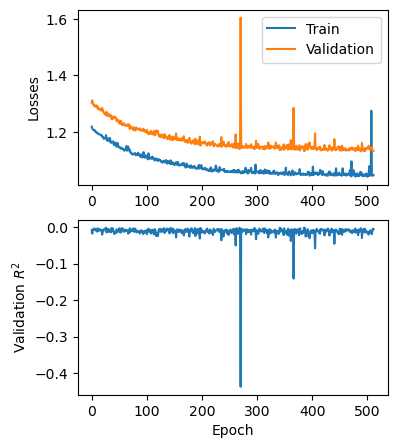

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(4, 5))
ax0.plot(train_losses, label='Train')
ax0.plot(validation_losses, label='Validation')
ax0.set_ylabel('Losses')
ax0.legend()
ax1.plot(validation_scores)
ax1.set_ylabel(r'Validation $R^2$')
ax1.set_xlabel('Epoch')

## Visualization

In [10]:
test_predictions = model(test_X).detach()

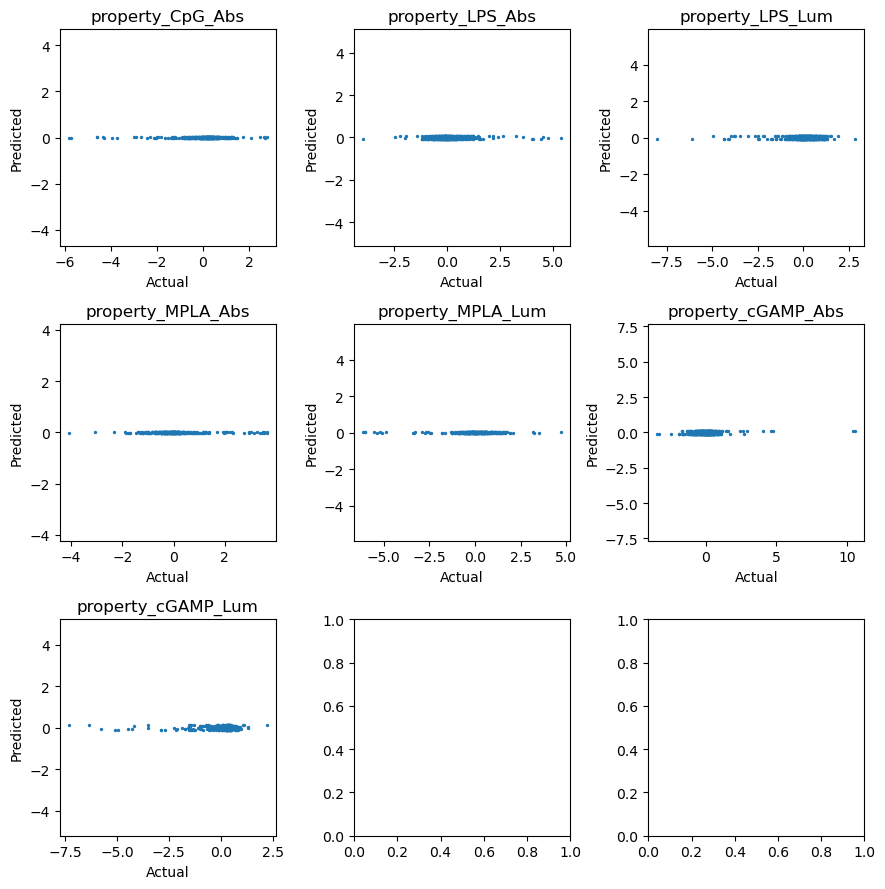

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i].cpu(), test_predictions[:, i].cpu(), s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()